## Synthetic saliency generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from scipy.signal import convolve2d

Leave these functions alone

In [22]:
def gkern(l=5, sig=1.):
    # side length `l`
    # sigma `sig`
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

def generate_focus_point(img, focus_points):
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    for idx, fp in enumerate(focus_points):
        p, r, fill_value = fp
        left_up_point = (p[0]-r, p[1]-r)
        right_down_point = (p[0]+r, p[1]+r)
        two_point_list = [left_up_point, right_down_point]
        draw.ellipse(two_point_list, fill=fill_value)
    img_np = np.array(img)
    kernel = gkern(30, 7)
    img_np = convolve2d(img_np, kernel, mode="same")
    return img_np

def plot_comparison_of_focus_points(axes, focus_points, changes, ref_mask=None):
    sal_1 = generate_focus_point(blank_img, focus_points)
    axes[0].imshow(sal_1)
    axes[0].set_title("Comparative")
    for idx, fp in enumerate(focus_points):
        xy, r, fill_value = fp
        x, y = xy
        axes[0].text(x-10, y+4, f'{idx}:{fill_value:.1f}', color="navy", fontsize=15)
        

    changed_focus_ps = []
    for idx, change in enumerate(changes):
        translate, scale, value = change
        fp = []
        pos = [focus_points[idx][0][0] + translate[0],  focus_points[idx][0][1] + translate[1]]
        fp.append(pos)
        fp.append(focus_points[idx][1] * scale)
        fp.append(focus_points[idx][2] * value)
        changed_focus_ps.append(fp)

    sal_2 = generate_focus_point(blank_img, changed_focus_ps)
    if ref_mask == None:
        axes[1].imshow(sal_2)
    else:
        axes[1].imshow(sal_2 * ref_mask)
        
    for idx, fp in enumerate(changed_focus_ps):
        xy, r, fill_value = fp
        x, y = xy
        axes[1].text(x-10, y+4, f'{idx}:{fill_value:.1f}', color="navy", fontsize=15)
    
    axes[1].set_title(f"Reference");
    
    return sal_1, sal_1

In [19]:
# You can change the dimension of the blank image if you want to. Dimension is 224 x 224
blank_img = np.zeros((224, 224))

# Original focos points, can be changed to any values within the image. Each element is a list that contains the following:
# - 1. First element is a list that contains the position of the focus point
# - 2. Followed by the radius of the focus point
# - 3. And finally, the last value is the saliency value for that focus point
focus_points = [[[140, 140], 20, 1.0], # 0
                [[130, 80], 15, 0.4], # 1
                [[100, 160], 10, 0.8], # 2
                [[160, 100], 16, 0.4], # 3
                [[75, 90], 15, 0.7]]  # 4


Text(10, 208.5, 'Metric=0.81')

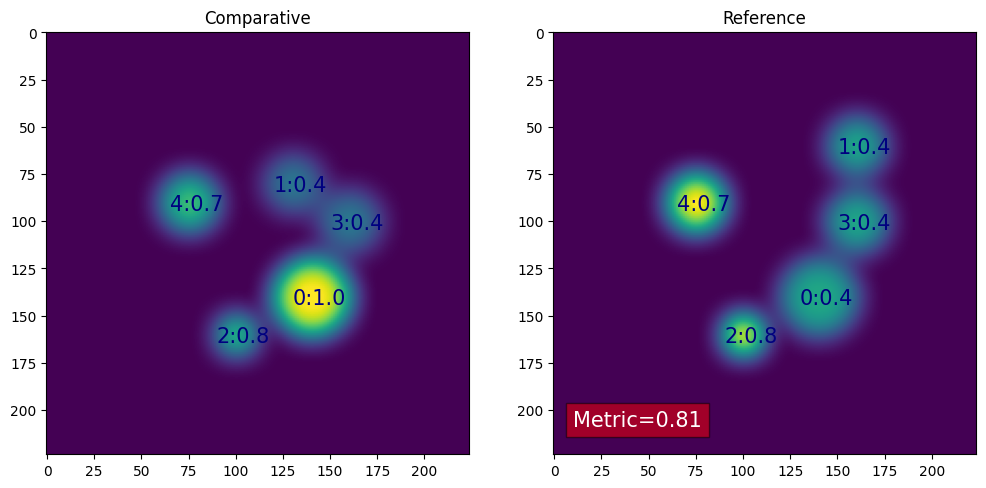

In [30]:
# Below we are using the original focus_points that are defined above for the comparative saliency.
# The reference saliency changes based on the `change` list that we give to the function (as can be seen below)
# Each element inside change list does the following:
# - The first element adds itself to the position of the original focus point
# - Second element (radius) multiplies to the original radius function
# - Last element (saliency value) also multiplies to the original value

# In here, therefore, for the first point, we are decreasing its saliency value by multiplying it with 0.4
# For the second point, we have moving the point 30 pixels in x and 20 pixels below in y. (Bear in mind that y start from top)
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figheight(12)
fig.set_figwidth(12)

sal_1, sal_2 = plot_comparison_of_focus_points(axes, focus_points, [[(0, 0), 1, 0.4], # 0
                                                                    [(30, -20), 1, 1], # 1
                                                                    [(0, 0), 1, 1], # 2
                                                                    [(0, 0), 1, 1], # 3
                                                                    [(0, 0), 1, 1]]); # 4

# Maybe you want to use this code to put your metric value onto the image
some_metric_value = 0.81
axes[1].text(10, axes[1].get_ylim()[0]-15, f"Metric={some_metric_value:.2f}", fontsize=15, color="white", bbox={'facecolor' : "red", "alpha" : 0.5, "pad" : 5}) 

### Adversarial Noise

In [2]:
import os
os.chdir("..")
os.getcwd()

'/project/validating_attribution_techniques'

In [3]:
from commons.api.method.adv_perturb import adversarial_noise

import torch
from torchvision.models import ResNet18_Weights, ResNet50_Weights, RegNet_Y_16GF_Weights
from torchvision import models
import numpy as np
from matplotlib import pyplot as plt

In [4]:
images = np.load("abid/data/ground_saliency_images/images_2_fixed.npy")

In [5]:
import json
def get_imagenet_classes(): 
    classes_json = "data/imagenet_class_index.json"
    classes = json.load(open(classes_json))
    classes = np.array(list(classes.values()))
    return classes[:, 1]

classes = get_imagenet_classes()

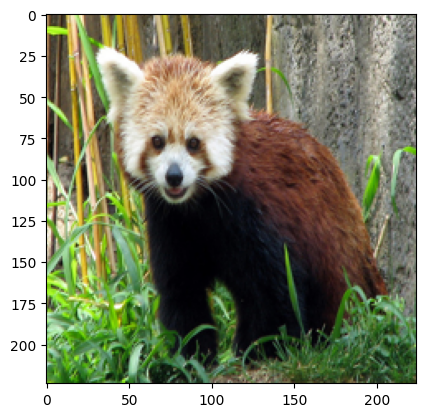

In [6]:
plt.imshow(images[0])

In [7]:
# In pytorch, the shape of images are different; the first dimension must be the image channel
in_ten = torch.tensor(images[0]).permute((2, 0, 1)).unsqueeze(0) / 255.0

# In case, we are using cuda for the model
in_ten = in_ten.to("cuda")
resnet_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to("cuda")
resnet_model.eval();

in_ten.shape

torch.Size([1, 3, 224, 224])

In [8]:
class_idx = torch.softmax(resnet_model(in_ten), 1)[0].argmax().cpu()
int(class_idx)

387

In [9]:
# Epsilon defines the intensity of the noise. Higher values changes the image more
out_ten = adversarial_noise(in_ten, resnet_model, int(class_idx), lower_bound=0, upper_bound=1, epsilon=0.009)
out_ten.shape

/scratch/hashimi/python/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


torch.Size([1, 3, 224, 224])

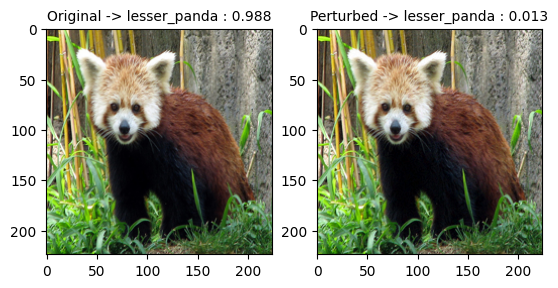

In [10]:
# Here we input the image back and see as the probability has decreased
ori_res = resnet_model(in_ten)
ori_probs = torch.softmax(ori_res, 1)
ori_idx = ori_probs.argmax()

adv_res = resnet_model(out_ten)
adv_probs = torch.softmax(adv_res, 1)
adv_idx = adv_probs.argmax()

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(images[0])
axes[0].set_title(f"Original -> {classes[ori_idx]} : {ori_probs[0, ori_idx]:.3f}", fontsize=10)

axes[1].imshow(out_ten[0].permute((1, 2, 0)).cpu().numpy())
axes[1].set_title(f"Perturbed -> {classes[ori_idx]} : {adv_probs[0, ori_idx]:.3f}", fontsize=10)
fig.show()

### Anti-adversarial

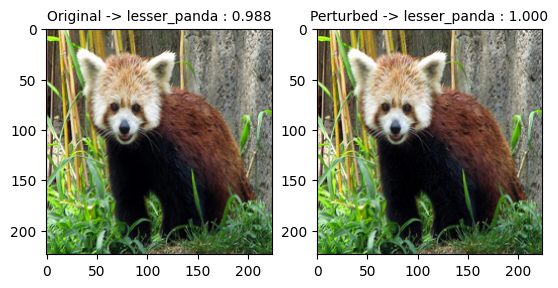

In [59]:
# The function accepts an argument to change the image such that it increases the probability

out_ten = adversarial_noise(in_ten, resnet_model, int(class_idx), lower_bound=0, upper_bound=1, epsilon=0.009, anti_adv=True)

ori_res = resnet_model(in_ten)
ori_probs = torch.softmax(ori_res, 1)
ori_idx = ori_probs.argmax()

adv_res = resnet_model(out_ten)
adv_probs = torch.softmax(adv_res, 1)
adv_idx = adv_probs.argmax()

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(images[0])
axes[0].set_title(f"Original -> {classes[ori_idx]} : {ori_probs[0, ori_idx]:.3f}", fontsize=10)

axes[1].imshow(out_ten[0].permute((1, 2, 0)).cpu().numpy())
axes[1].set_title(f"Perturbed -> {classes[ori_idx]} : {adv_probs[0, ori_idx]:.3f}", fontsize=10)
fig.show()

### Noise with Mask

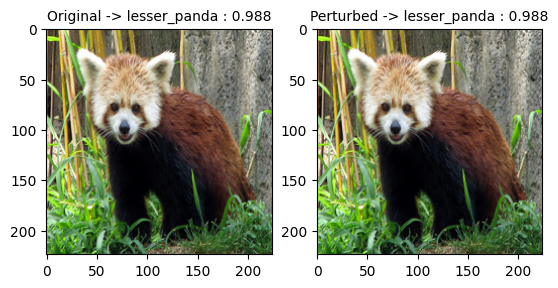

In [13]:
# Imagine if the mask is all zero'd out (meaning, no noise should be added anywhere)
mask_ten = torch.zeros_like(in_ten)
out_ten = adversarial_noise(in_ten, resnet_model, int(class_idx), lower_bound=0, upper_bound=1, epsilon=0.009, mask=mask_ten)
out_ten.shape
ori_res = resnet_model(in_ten)
ori_probs = torch.softmax(ori_res, 1)
ori_idx = ori_probs.argmax()

adv_res = resnet_model(out_ten)
adv_probs = torch.softmax(adv_res, 1)
adv_idx = adv_probs.argmax()

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(images[0])
axes[0].set_title(f"Original -> {classes[ori_idx]} : {ori_probs[0, ori_idx]:.3f}", fontsize=10)

axes[1].imshow(out_ten[0].permute((1, 2, 0)).cpu().numpy())
axes[1].set_title(f"Perturbed -> {classes[ori_idx]} : {adv_probs[0, ori_idx]:.3f}", fontsize=10)
fig.show()

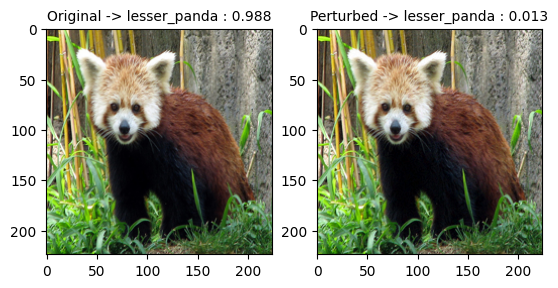

In [14]:
# Now the mask is all 1s (meaning, everywhere is permitted to have noise)
mask_ten = torch.ones_like(in_ten)
out_ten = adversarial_noise(in_ten, resnet_model, int(class_idx), lower_bound=0, upper_bound=1, epsilon=0.009, mask=mask_ten)
out_ten.shape
ori_res = resnet_model(in_ten)
ori_probs = torch.softmax(ori_res, 1)
ori_idx = ori_probs.argmax()

adv_res = resnet_model(out_ten)
adv_probs = torch.softmax(adv_res, 1)
adv_idx = adv_probs.argmax()

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(images[0])
axes[0].set_title(f"Original -> {classes[ori_idx]} : {ori_probs[0, ori_idx]:.3f}", fontsize=10)

axes[1].imshow(out_ten[0].permute((1, 2, 0)).cpu().numpy())
axes[1].set_title(f"Perturbed -> {classes[ori_idx]} : {adv_probs[0, ori_idx]:.3f}", fontsize=10)
fig.show()

### Multipatch Occlusion

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from commons.api.multi_occu import generate_multipatch_occlusion_list_reduce_saliency

images = np.load("abid/data/ground_saliency_images/images_2_fixed.npy")

In [5]:
img = images[0]
patch_size = 40
num_patches = 5
tries = 16
occ_imgs, _ = generate_multipatch_occlusion_list_reduce_saliency(images[0], patch_size, num_patches, tries)

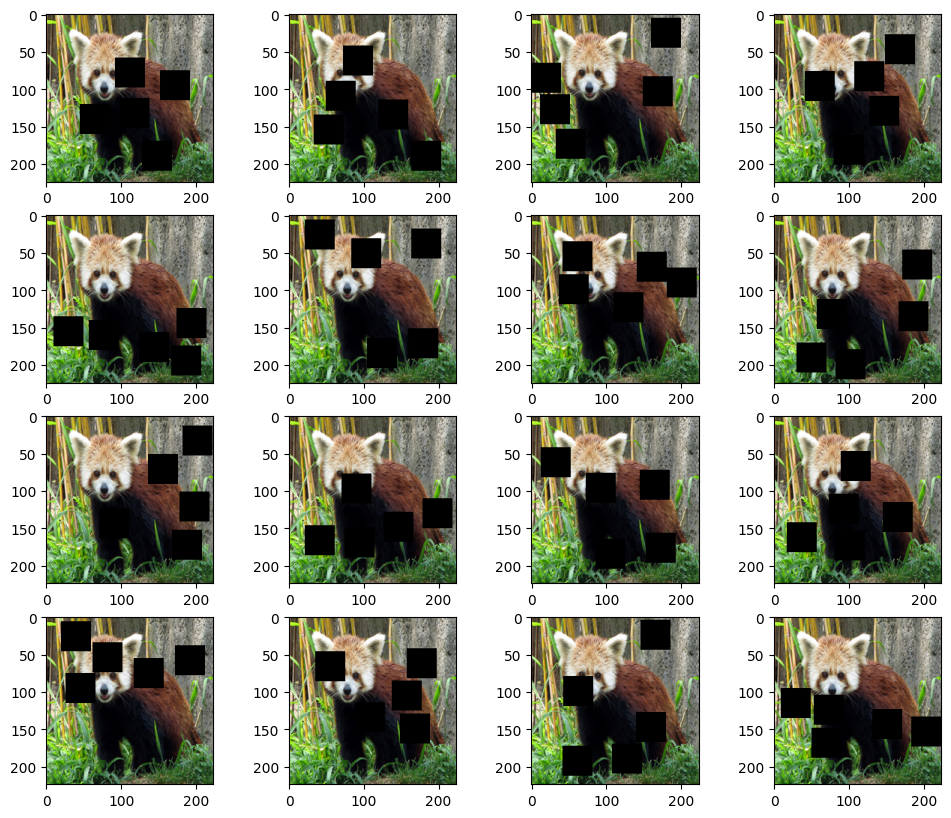

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=4)
fig.set_figheight(10)
fig.set_figwidth(12)

for idx, axis in enumerate(axes.flat):
    if idx >= occ_imgs.shape[0]: break
    axis.imshow(occ_imgs[idx])

In [9]:
# NOTE: The function also accepts saliency map as an additional argument, and it will return the sum of
#       saliency value of all the occluded regions in the image as a second return value.